<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1">1. Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li><li><span><a href="#1.1-Лемматизация" data-toc-modified-id="1.1-Лемматизация-1.2">1.1 Лемматизация</a></span></li><li><span><a href="#1.2-Визуализируем-слова-из-разных-классов" data-toc-modified-id="1.2-Визуализируем-слова-из-разных-классов-1.3">1.2 Визуализируем слова из разных классов</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4">Вывод</a></span></li><li><span><a href="#1.3-Векторизация-TF-IDF" data-toc-modified-id="1.3-Векторизация-TF-IDF-1.5">1.3 Векторизация TF-IDF</a></span></li></ul></li><li><span><a href="#2.-Обучение" data-toc-modified-id="2.-Обучение-2">2. Обучение</a></span><ul class="toc-item"><li><span><a href="#2.1-Логистическая-регрессия" data-toc-modified-id="2.1-Логистическая-регрессия-2.1">2.1 Логистическая регрессия</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2">Вывод</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3">Вывод</a></span></li><li><span><a href="#2.2-Дерево-решений" data-toc-modified-id="2.2-Дерево-решений-2.4">2.2 Дерево решений</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5">Вывод</a></span></li><li><span><a href="#2.3-CatBoost" data-toc-modified-id="2.3-CatBoost-2.6">2.3 CatBoost</a></span></li></ul></li><li><span><a href="#3.-Выводы" data-toc-modified-id="3.-Выводы-3">3. Выводы</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-4"> Комментарий ревьюера</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5">Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

In [1]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 1.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
import time

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
tqdm.pandas()
import transformers 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,  precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, cv, Pool
import lightgbm as lgb
from sklearn.svm import LinearSVC
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# загрузим и посмотрим данные
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# загрузка пакетов для лемматизации
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# соотношение классов
df['toxic'].value_counts() / df['toxic'].shape[0]

0    0.898321
1    0.101679
Name: toxic, dtype: float64

In [6]:
# дубликаты
df.duplicated().sum()

0

### Вывод
Соотношение классов в данных приблизительно 9/1. Дубликатов не обнаружено.

### 1.1 Лемматизация
Для дальнейшей работы необходимо очистить данные от знаков препинания, сокращений, цифр, стоп-слов. А также привести слова к начальной форме. Для этого используем WordNetLemmatizer.

In [7]:
# экземпляр для лемматизации
lemmatizer = WordNetLemmatizer()

In [8]:
# функция для pos-tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
# стоп-слова
stop_words = set(stopwords.words("english"))
# функция очистки текста от символов и стоп-слов
def clean(row):
    row = row.lower()
    row = re.sub(r"don't", ' do not', row)
    row = re.sub(r"can't", 'can not', row)
    row = re.sub(r"'ve", ' have', row)
#     row = re.sub(r"'t", ' not', row)
    row = re.sub(r"'m", ' am', row)
    row = re.sub(r"'re", ' are', row)
    row = re.sub(r"'s", ' is', row)
    row = ' '.join([word for word in nltk.word_tokenize(row) if not word in stop_words])
    return ' '.join((re.sub(r"[^a-zA-Z']", ' ', row)).split())

In [10]:
# функция лемматизации
def lem_text(row):
    lem = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(row)])
    return lem

In [11]:
# очищаем данные и передаем в новый столбец
df['lem_text'] = df['text'].progress_apply(clean)

In [12]:
# лемматизация
df['lem_text'] = df['lem_text'].progress_apply(lem_text)

### 1.2 Визуализируем слова из разных классов

In [13]:
# функция перевода к одной строке
def to_text(df,cat_id):
    return '|'.join(df[df['toxic']==cat_id]['lem_text'])

# функция визуализии
def plot_cat(df, cat_id, figsize):
    plt.figure(figsize=figsize)
    text = to_text(df, cat_id)
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

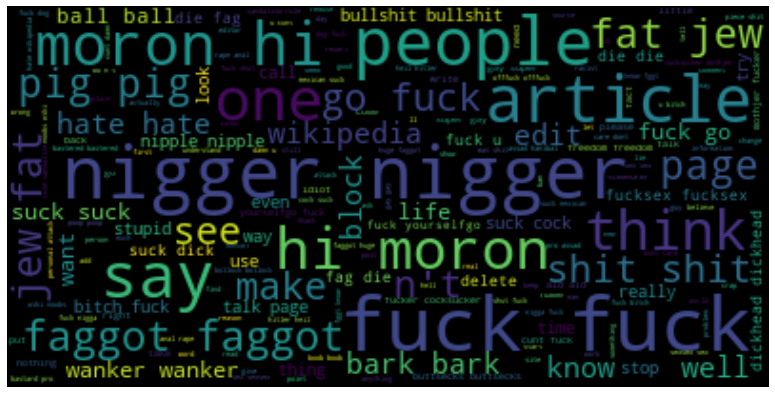

In [14]:
### токсичные комментарии
plot_cat(df=df, cat_id=1, figsize=(15,7))

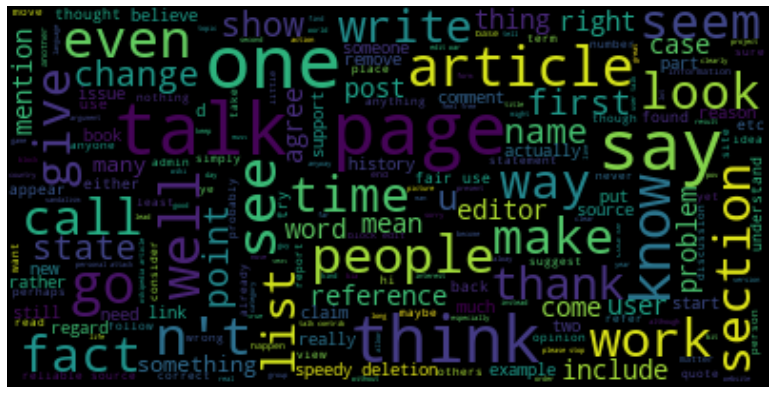

In [15]:
### нетоксичные комментарии
plot_cat(df=df, cat_id=0, figsize=(15,7))

### Вывод
Для токсичных комментариев получилось довольно наглядно.

### 1.3 Векторизация TF-IDF
Преобразованные данные приведем в векторный вид методом TF-IDF

In [16]:
# разобьем данные на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.25)


train_features = train.drop(['toxic', 'text'], axis=1)
train_target = train['toxic']

test_features_first = test.drop(['toxic', 'text'], axis=1)
test_target = test['toxic']

In [17]:
# соотношение классов
train_target.value_counts() / train_target.shape[0]

0    0.89872
1    0.10128
Name: toxic, dtype: float64

In [18]:
count_tf_idf = TfidfVectorizer()

In [19]:
# векторизуем лемматизированные сообщения в обучающей выборке
df_tf_idf = count_tf_idf.fit_transform(train_features['lem_text'])

In [20]:
# векторизуем лемматизированные сообщения в тестовой выборке
test_features = count_tf_idf.transform(test_features_first['lem_text'])

## 2. Обучение

### 2.1 Логистическая регрессия
Логистическую регрессию обучим на обучающей выборке, далее проверим на тестовой выборке и подберем оптимальный порог вероятности.

In [21]:
model_lr = LogisticRegression(random_state=1, max_iter=500)

In [22]:
def find_threshold(model, x, y):
    proba = cross_val_predict(model, x, y, cv=5, method='predict_proba',n_jobs=-1)
    proba_one = proba[:, 1]
    max_f1 = 0
    best_threshold = 0
    for threshold in tqdm(np.arange(0, 0.95, 0.02)):
        predicted = proba_one > threshold
        f1 = f1_score(y, predicted)
        if f1 > max_f1:
            max_f1 = f1
            best_threshold = threshold
    return max_f1, best_threshold

In [23]:
max_f1, best_threshold = find_threshold(model_lr,df_tf_idf,train_target)
f'F1 логистической регрессии на тренировочной выборке равно {round((max_f1), 3)}, при пороге равном {round((best_threshold), 3)}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'F1 логистической регрессии на тренировочной выборке равно 0.781, при пороге равном 0.24'

In [25]:
# предсказание вероятностей
model_lr.fit(df_tf_idf,train_target)
probabilities_test = model_lr.predict_proba(test_features)

In [26]:
probabilities_one_test = probabilities_test[:, 1]
predicted = probabilities_one_test > best_threshold
f1_test = f1_score(test_target, predicted)
f'F1 логистической регрессии на тестовой выборке равно {round((f1_test), 3)}'

'F1 логистической регрессии на тестовой выборке равно 0.791'

In [28]:
#функция для графиков roc и precision-recall
def graph(fpr,tpr,precision,recall,auc_roc,f1,threshold):
    fig, axes = plt.subplots(ncols=2,figsize=(18,6))

    axes[0].plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    axes[0].plot([0, 1], [0, 1], linestyle='--')
    axes[0].set_xlim([0.0,1.0])
    axes[0].set_ylim([0.0,1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC-кривая')
    axes[0].grid(True)

    add_titlebox(ax=axes[0], text=f'AUC_ROC = {auc_roc.round(3)}',x=0.25,y=0.7)


    axes[1].step(recall, precision, where='post')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Кривая Precision-Recall')
    axes[1].grid(True)
    add_titlebox(ax=axes[1], text=f'F1_score = {f1.round(3)}',x=0.25,y=0.7)
    add_titlebox(ax=axes[1], text=f'threshold = {threshold.round(3)}',x=0.25,y=0.5)
    plt.show()

In [29]:
#функция для подписей на графиках
def add_titlebox(ax, text, x,y):
    ax.text(x, y, text, horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='green', alpha=0.6),
        fontsize=12.5)
    return ax

In [30]:
#функция для матрицы ошибок
def conf_matrix(pv,tv):
    cm = pd.DataFrame(confusion_matrix(pv,tv), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
    display(cm)

In [31]:
# функция обновления таблицы результатов
def res_data(df, f1, name):
    df = df.append(pd.Series(data={'F1':f1}, name=name), ignore_index=False)
    return df

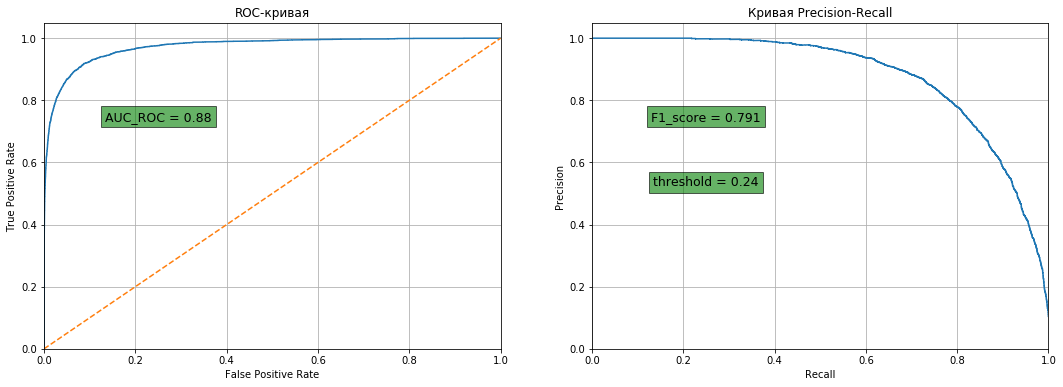

,predicted 0,predicted 1
actual 0,34983,889
actual 1,806,3215


In [32]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
#precision-recall-кривая
precision, recall, thresholds = precision_recall_curve(test_target, probabilities_one_test)
auc_roc = roc_auc_score(test_target, predicted)
graph(fpr,tpr,precision,recall,auc_roc,f1_test, best_threshold)
# матрица ошибок
conf_matrix(predicted, test_target)

In [33]:
# посмотрим на матрицу ошибок и auc_roc при пороге 0.5
pred5 = model_lr.predict(test_features)
conf_matrix(pred5, test_target)
roc_auc_score(test_target, probabilities_test[:, 1])

,predicted 0,predicted 1
actual 0,35568,1511
actual 1,221,2593


0.9721505845638372

In [34]:
results = pd.DataFrame({'F1':f1_test}, index = ['Логистическая регрессия'])
results

,F1
Логистическая регрессия,0.791385


### Вывод
Как видно, без подбора порога значение AUC-ROC выше, но хуже точность(precision) определения токсичных комментариев.

Далее подберем гиперпараметры модели логистической регрессии.

In [35]:
# подготовка для GridSearchCV на выборке
C = [3.5,3.6,3.7,3.8]
param_grid = {'C' : C}

In [36]:
model_lr = LogisticRegression(random_state=1, max_iter=500, penalty='l1')
gs = GridSearchCV(model_lr, param_grid, cv = 5, verbose = 5, n_jobs=-1,scoring='f1')
gs.fit(df_tf_idf,train_target)
model_lr = gs.best_estimator_
display(gs.best_params_)

f'F1 логистической регрессии на тренировочной выборке равно {round((gs.best_score_), 3)}'

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=3.5 ...........................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] ............................... C=3.5, score=0.779, total=   2.8s
[CV] C=3.5 ...........................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ............................... C=3.5, score=0.772, total=   2.5s
[CV] C=3.5 ...........................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] ............................... C=3.5, score=0.778, total=   2.5s
[CV] C=3.5 ...........................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


[CV] ............................... C=3.5, score=0.776, total=   2.5s
[CV] C=3.5 ...........................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.3s remaining:    0.0s


[CV] ............................... C=3.5, score=0.773, total=   2.6s
[CV] C=3.6 ...........................................................
[CV] ............................... C=3.6, score=0.779, total=   2.9s
[CV] C=3.6 ...........................................................
[CV] ............................... C=3.6, score=0.772, total=   2.4s
[CV] C=3.6 ...........................................................
[CV] ............................... C=3.6, score=0.779, total=   2.6s
[CV] C=3.6 ...........................................................
[CV] ............................... C=3.6, score=0.775, total=   2.8s
[CV] C=3.6 ...........................................................
[CV] ............................... C=3.6, score=0.773, total=   2.4s
[CV] C=3.7 ...........................................................
[CV] ............................... C=3.7, score=0.779, total=   2.6s
[CV] C=3.7 ...........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.1s finished


{'C': 3.8}

'F1 логистической регрессии на тренировочной выборке равно 0.776'

In [37]:
# подберем порог
max_f1, best_threshold = find_threshold(model_lr,df_tf_idf,train_target)

f'F1 логистической регрессии на тренировочной выборке равно {round((max_f1), 3)}, при пороге равном {round((best_threshold), 3)}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'F1 логистической регрессии на тренировочной выборке равно 0.784, при пороге равном 0.3'

In [38]:
# предсказания на тестовой выборке при подобранном пороге
probabilities_test = model_lr.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
predicted = probabilities_one_test > best_threshold
f1_test = f1_score(test_target, predicted)

f'F1 логистической регрессии на тестовой выборке равно {round((f1_test), 3)}'

'F1 логистической регрессии на тестовой выборке равно 0.798'

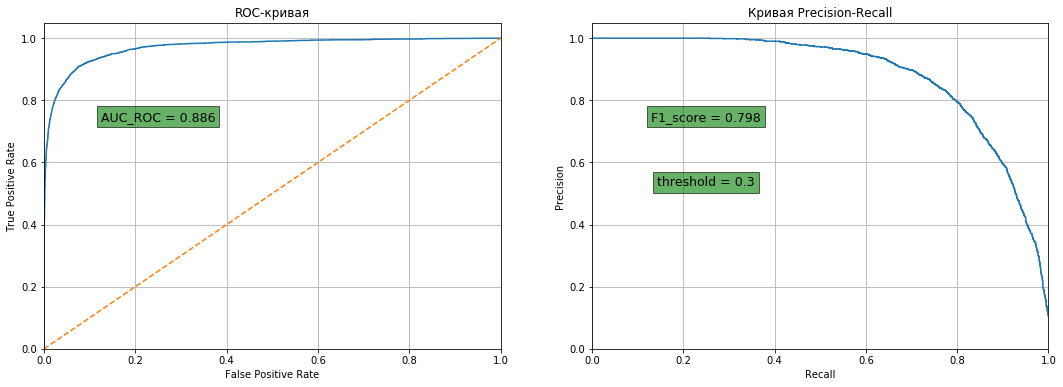

,predicted 0,predicted 1
actual 0,34983,842
actual 1,806,3262


In [39]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(test_target, probabilities_test[:, 1])
#precision-recall-кривая
precision, recall, thresholds = precision_recall_curve(test_target, probabilities_one_test)
auc_roc = roc_auc_score(test_target, predicted)
graph(fpr,tpr,precision,recall,auc_roc,f1_test, best_threshold)
# матрица ошибок
conf_matrix(predicted, test_target)

In [40]:
results = res_data(results, max_f1, 'Логистическая регрессия(GS)')

### Вывод
После подбора гиперпараметров метрика F1 незначительно улучшилась, также немного улучшилась точность(precision) определения токсичных комментариев.

### 2.2 Дерево решений

In [41]:
clf = DecisionTreeClassifier(random_state=1, max_depth=50)

In [42]:
%%time
max_f1, best_threshold = find_threshold(clf,df_tf_idf,train_target)
f'F1 дерева решений на тренировочной выборке равно {round((max_f1), 3)}, при пороге равном {round((best_threshold), 3)}'


CPU times: user 3min 42s, sys: 110 ms, total: 3min 42s
Wall time: 3min 43s


'F1 дерева решений на тренировочной выборке равно 0.709, при пороге равном 0.26'

In [43]:
# предсказание вероятностей
clf.fit(df_tf_idf,train_target)
probabilities_test = clf.predict_proba(test_features)

In [44]:
probabilities_one_test = probabilities_test[:, 1]
predicted = probabilities_one_test > best_threshold
f1_test = f1_score(test_target, predicted)
f'F1 дерева решений на тестовой выборке равно {round((max_f1), 3)}'

'F1 дерева решений на тестовой выборке равно 0.709'

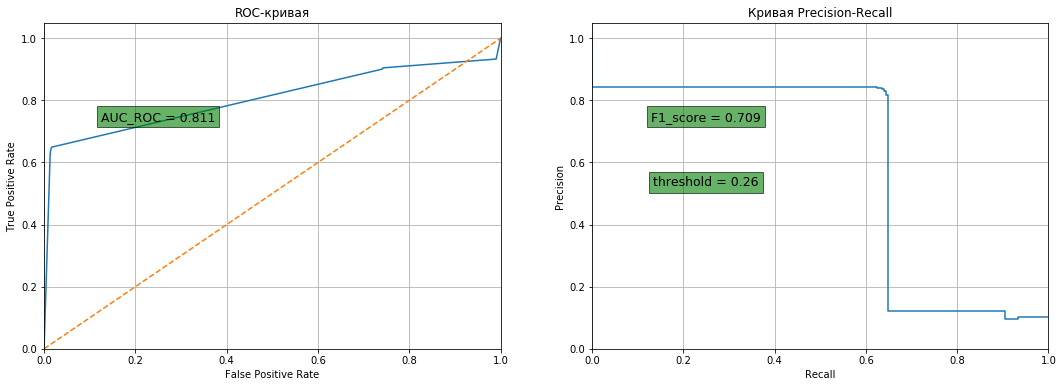

,predicted 0,predicted 1
actual 0,35284,1495
actual 1,505,2609


In [48]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(test_target, probabilities_test[:, 1])
#precision-recall-кривая
precision, recall, thresholds = precision_recall_curve(test_target, probabilities_one_test)
auc_roc = roc_auc_score(test_target, predicted)
graph(fpr,tpr,precision,recall,auc_roc,max_f1, best_threshold)
# матрица ошибок
conf_matrix(predicted, test_target)

In [49]:
# посмотрим на матрицу ошибок и auc_roc при пороге 0.5
pred5 = clf.predict(test_features)
conf_matrix(pred5, test_target)
roc_auc_score(test_target, probabilities_test[:, 1])

,predicted 0,predicted 1
actual 0,35289,1501
actual 1,500,2603


0.8059248517014685

In [50]:
results = res_data(results, max_f1, 'Дерево решений')

### Вывод
Как видно, без подбора порога значение AUC-ROC немного ниже, также хуже точность(precision) определения токсичных комментариев.

### 2.3 CatBoost



In [51]:
%%time
model_cat = CatBoostClassifier(eval_metric='F1',iterations=150, verbose=10)

CPU times: user 108 µs, sys: 7 µs, total: 115 µs
Wall time: 121 µs


In [52]:
max_f1, best_threshold = find_threshold(model_cat,df_tf_idf,train_target)
f'F1 CatBoost на тренировочной выборке равно {round((max_f1), 3)}, при пороге равном {round((best_threshold), 3)}'

Learning rate set to 0.330276
0:	learn: 0.4625331	total: 4.52s	remaining: 11m 14s
10:	learn: 0.5941618	total: 41s	remaining: 8m 38s
20:	learn: 0.6524222	total: 1m 18s	remaining: 8m 1s
30:	learn: 0.6700541	total: 1m 56s	remaining: 7m 25s
40:	learn: 0.6927952	total: 2m 33s	remaining: 6m 48s
50:	learn: 0.7120546	total: 3m 11s	remaining: 6m 11s
60:	learn: 0.7256693	total: 3m 48s	remaining: 5m 33s
70:	learn: 0.7362980	total: 4m 26s	remaining: 4m 56s
80:	learn: 0.7419995	total: 5m 3s	remaining: 4m 18s
90:	learn: 0.7502620	total: 5m 41s	remaining: 3m 41s
100:	learn: 0.7568397	total: 6m 18s	remaining: 3m 3s
110:	learn: 0.7601688	total: 6m 55s	remaining: 2m 26s
120:	learn: 0.7664234	total: 7m 34s	remaining: 1m 48s
130:	learn: 0.7700515	total: 8m 12s	remaining: 1m 11s
140:	learn: 0.7740609	total: 8m 50s	remaining: 33.9s
149:	learn: 0.7763769	total: 9m 24s	remaining: 0us
Learning rate set to 0.330277
0:	learn: 0.4823307	total: 4.69s	remaining: 11m 38s
10:	learn: 0.5714700	total: 43.4s	remaining: 

'F1 CatBoost на тренировочной выборке равно 0.773, при пороге равном 0.24'

In [53]:
# предсказание вероятностей
model_cat.fit(df_tf_idf,train_target)
probabilities_test = model_cat.predict_proba(test_features)

Learning rate set to 0.351807
0:	learn: 0.5115143	total: 5.7s	remaining: 14m 9s
10:	learn: 0.5829134	total: 53s	remaining: 11m 9s
20:	learn: 0.6642615	total: 1m 40s	remaining: 10m 18s
30:	learn: 0.6855775	total: 2m 27s	remaining: 9m 25s
40:	learn: 0.7019541	total: 3m 13s	remaining: 8m 35s
50:	learn: 0.7174407	total: 3m 59s	remaining: 7m 45s
60:	learn: 0.7308691	total: 4m 46s	remaining: 6m 57s
70:	learn: 0.7388845	total: 5m 32s	remaining: 6m 9s
80:	learn: 0.7456707	total: 6m 17s	remaining: 5m 21s
90:	learn: 0.7532124	total: 7m 3s	remaining: 4m 34s
100:	learn: 0.7608061	total: 7m 49s	remaining: 3m 47s
110:	learn: 0.7652443	total: 8m 35s	remaining: 3m 1s
120:	learn: 0.7706936	total: 9m 21s	remaining: 2m 14s
130:	learn: 0.7733603	total: 10m 7s	remaining: 1m 28s
140:	learn: 0.7771423	total: 10m 53s	remaining: 41.7s
149:	learn: 0.7792220	total: 11m 35s	remaining: 0us


In [54]:
probabilities_one_test = probabilities_test[:, 1]
predicted = probabilities_one_test > best_threshold
f1_test = f1_score(test_target, predicted)
f'F1 CatBoost на тестовой выборке равно {round((f1_test), 3)}'

'F1 CatBoost на тестовой выборке равно 0.788'

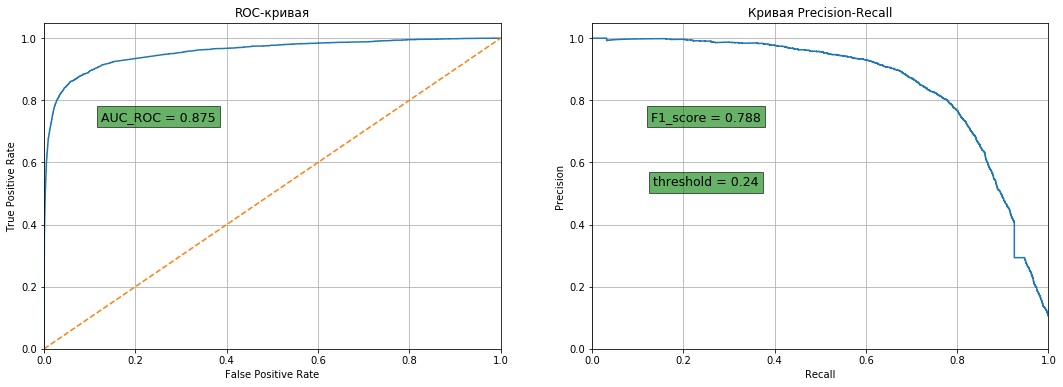

,predicted 0,predicted 1
actual 0,35024,937
actual 1,765,3167


In [55]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(test_target, probabilities_test[:, 1])
#precision-recall-кривая
precision, recall, thresholds = precision_recall_curve(test_target, probabilities_one_test)
auc_roc = roc_auc_score(test_target, predicted)
graph(fpr,tpr,precision,recall,auc_roc,f1_test, best_threshold)
# матрица ошибок
conf_matrix(predicted, test_target)

In [56]:
results = res_data(results, max_f1, 'CatBoostClassifier')
results

,F1
Логистическая регрессия,0.791385
Логистическая регрессия(GS),0.784430
Дерево решений,0.708874
CatBoostClassifier,0.772782


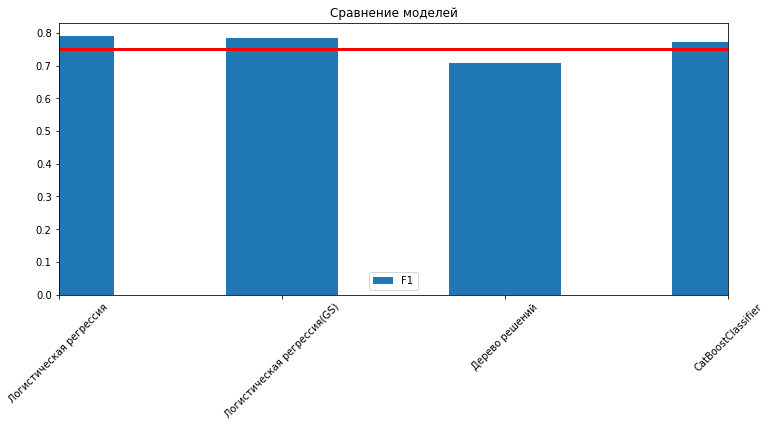

In [57]:
results.plot(kind='bar', title='Сравнение моделей', rot=45, figsize=(12,5), mark_right=True)
con = pd.Series(data=0.75, index=results.index)
con.plot(color='r', rot=45, linewidth=3)

## 3. Выводы

Первичный анализ данных показал, что соотношение классов в данных приблизительно 9/1. Дубликатов не обнаружено.
Далее данные были очищены от знаков препинания, сокращений, цифр, стоп-слов. А также приведены к начальной форме. Для этого используем WordNetLemmatizer.
Далее мы преобразовали данные к векторному виду.
Далее были обучены модели  лгоистической регрессии, дерева решений и CatBoost. Результаты см. график выше.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны